In [1]:
import Libraries.fplibrary.exploration as e
import Libraries.fplibrary.feature_engineering as f
import Libraries.fplibrary.loading_data as l
import Libraries.fplibrary.preprocessing as p
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter("ignore")

## Loading data

In [2]:
data_loader = l.DataLoader('data/apartments_pl_2023.csv')
train_data, test_data = data_loader.load_and_split_data()

# Merge train and test data for data exploration and pre-processing
train_data['is_train']=1
test_data['is_train']=0

all_data = pd.concat([train_data,test_data]).reset_index()

## Data exploration

In [3]:
# Define plots class
plots = e.ExplorationPlots(all_data)

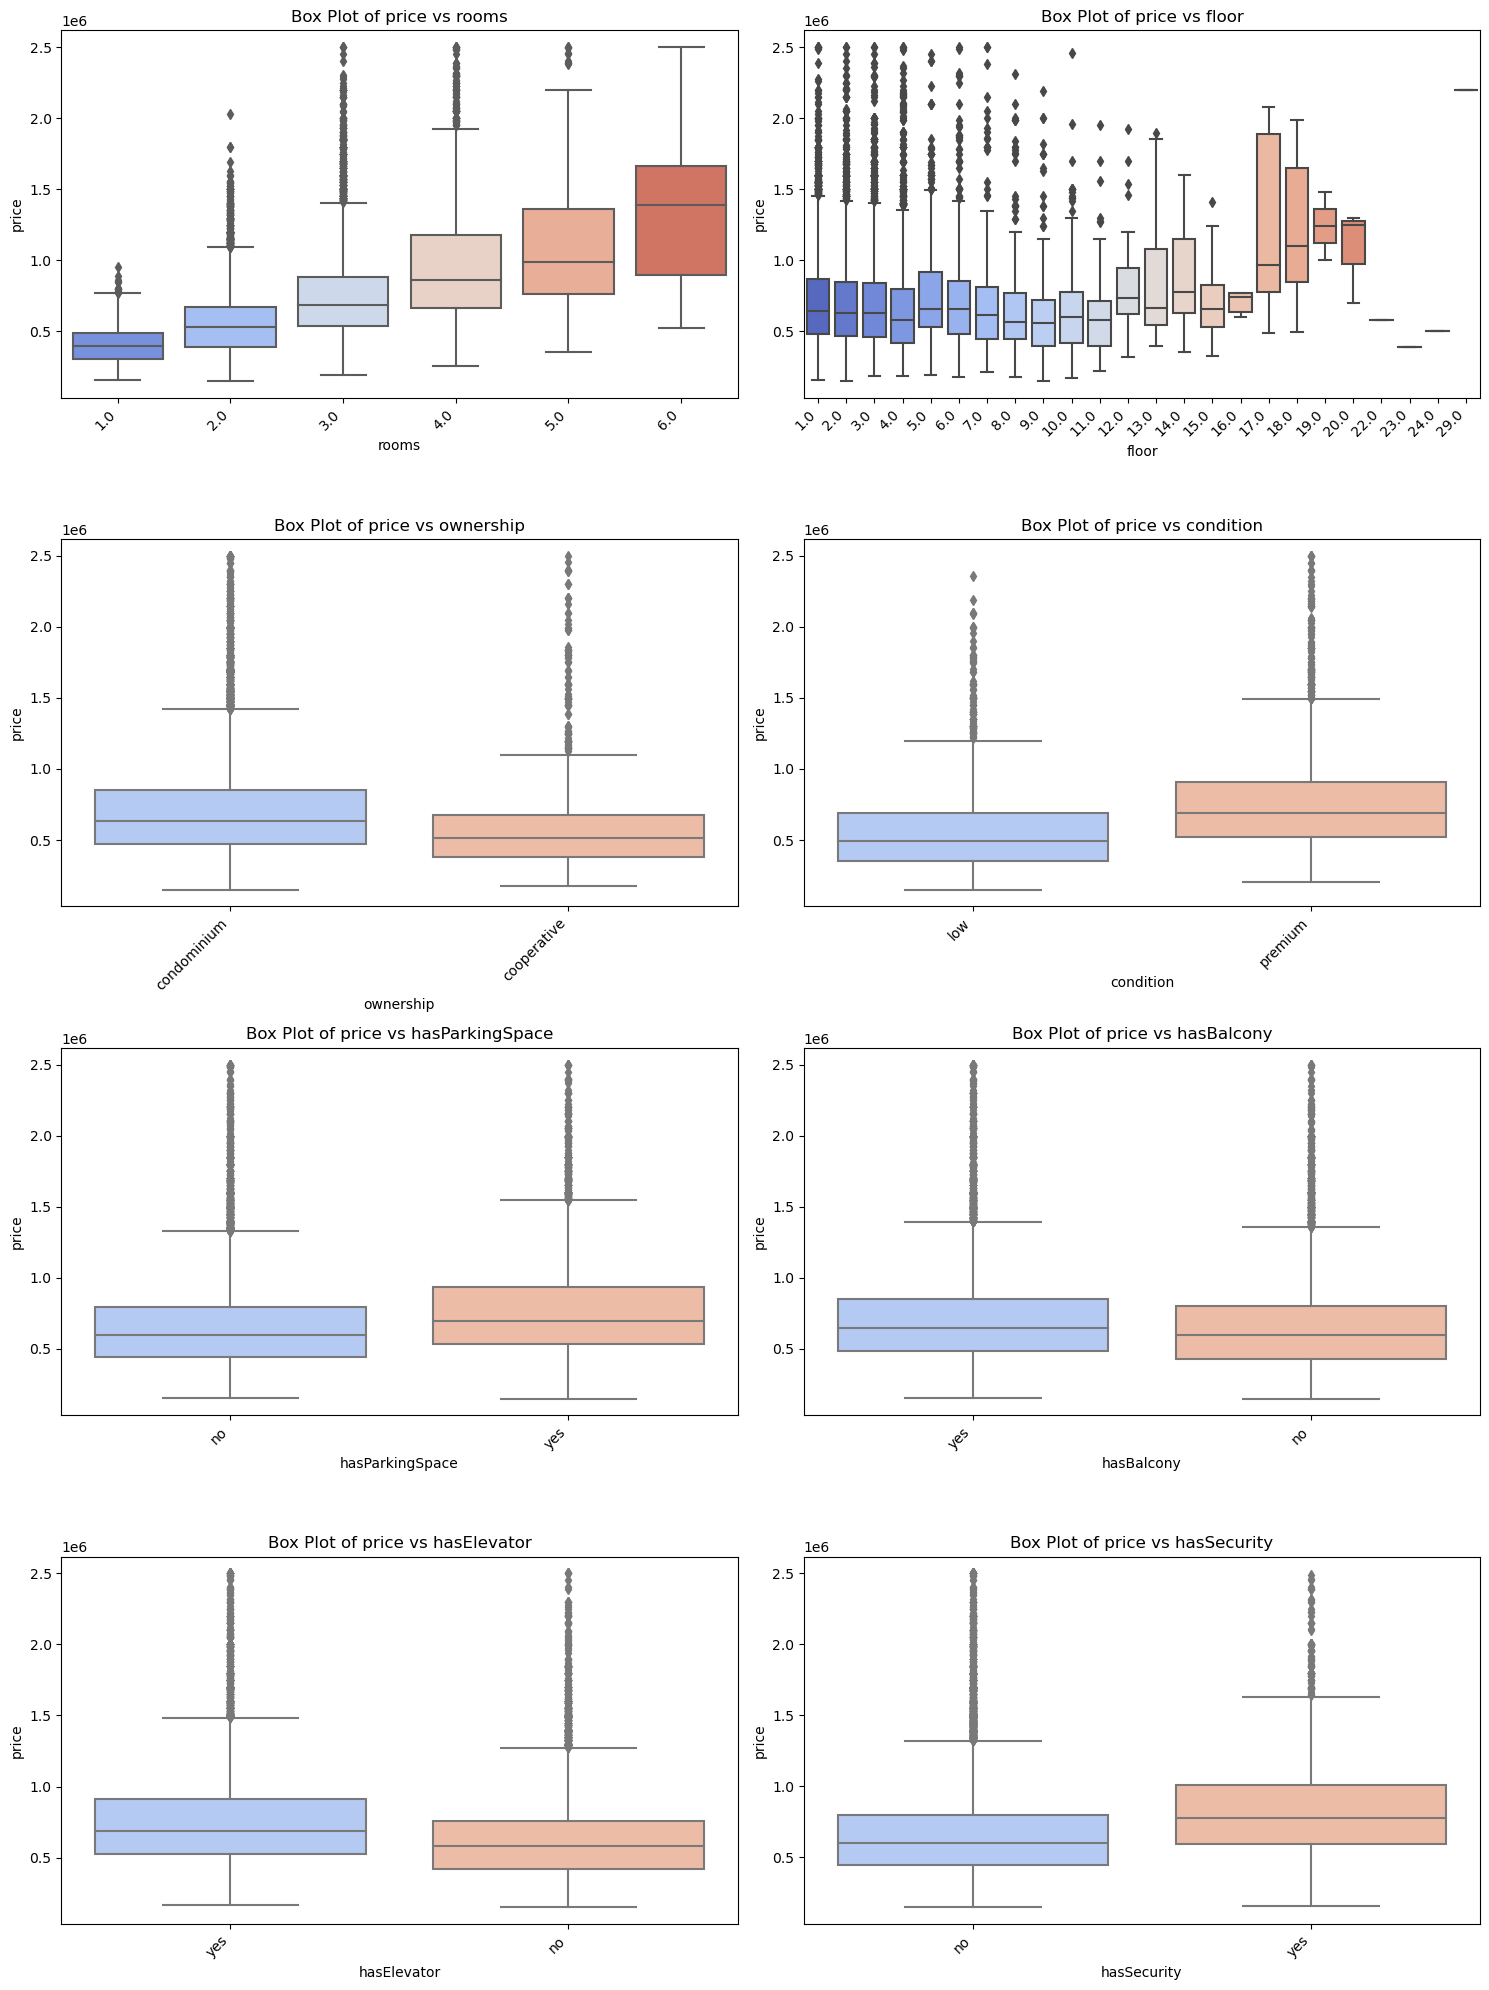

In [4]:
# Boxplots of price with categorical variables
plots.create_boxplot('price', ['rooms', 'floor', 'ownership', 'condition', 'hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity'], n_rows=4, n_cols=2)

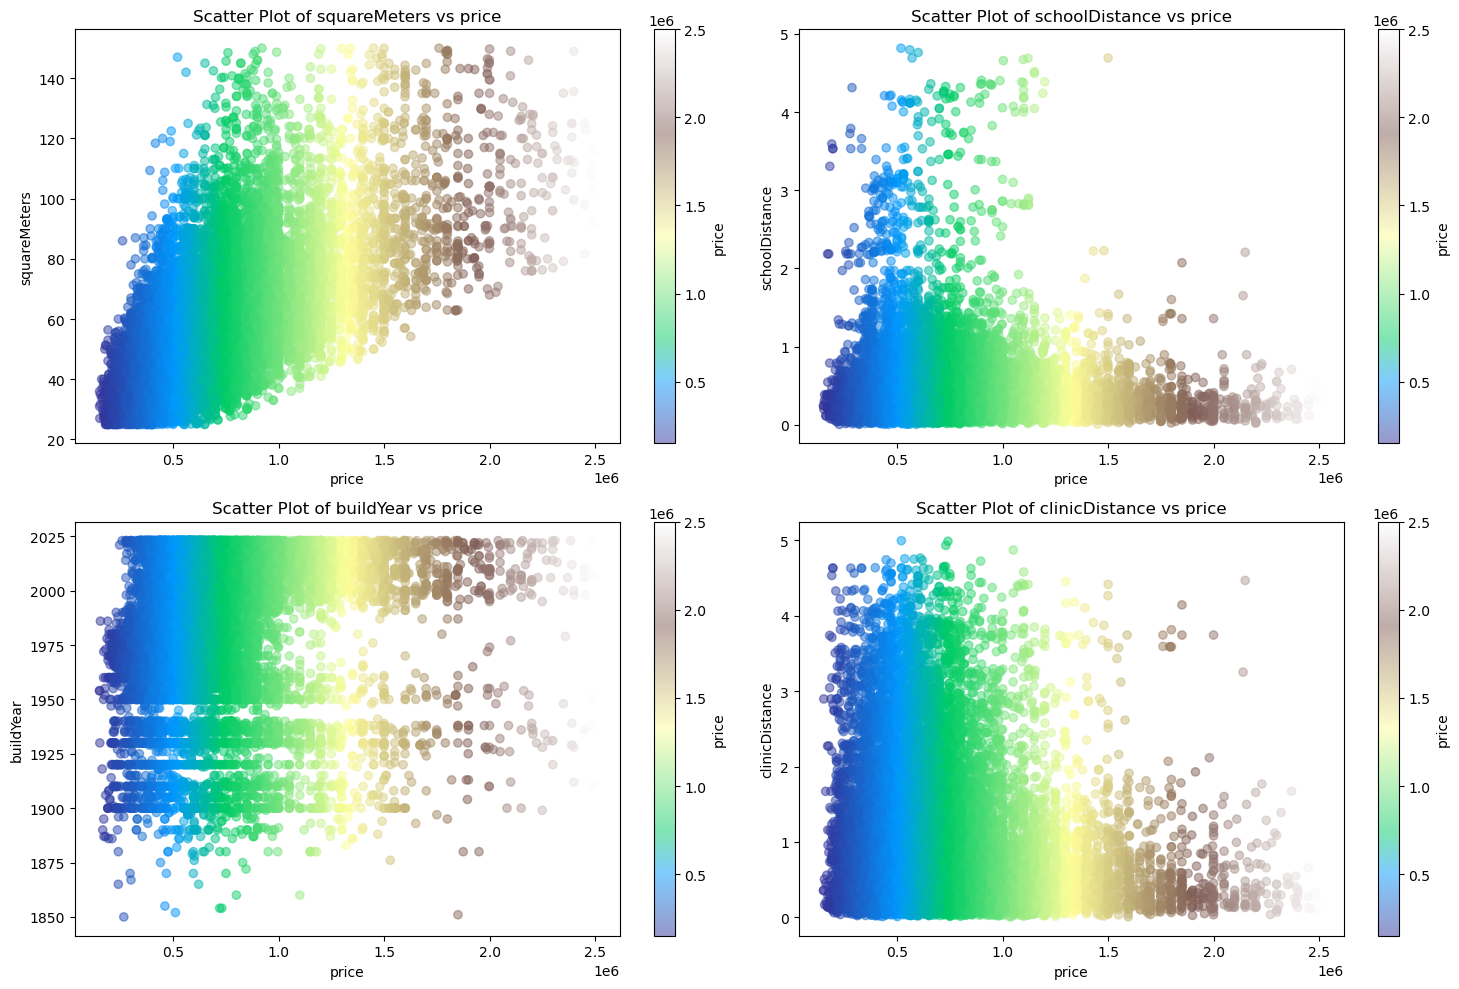

In [5]:
# Scatter plots
plots.create_scatter_plot([('price', 'squareMeters'), ('price', 'schoolDistance'), ('price', 'buildYear'), ('price', 'clinicDistance')], n_cols=2, n_rows=2)

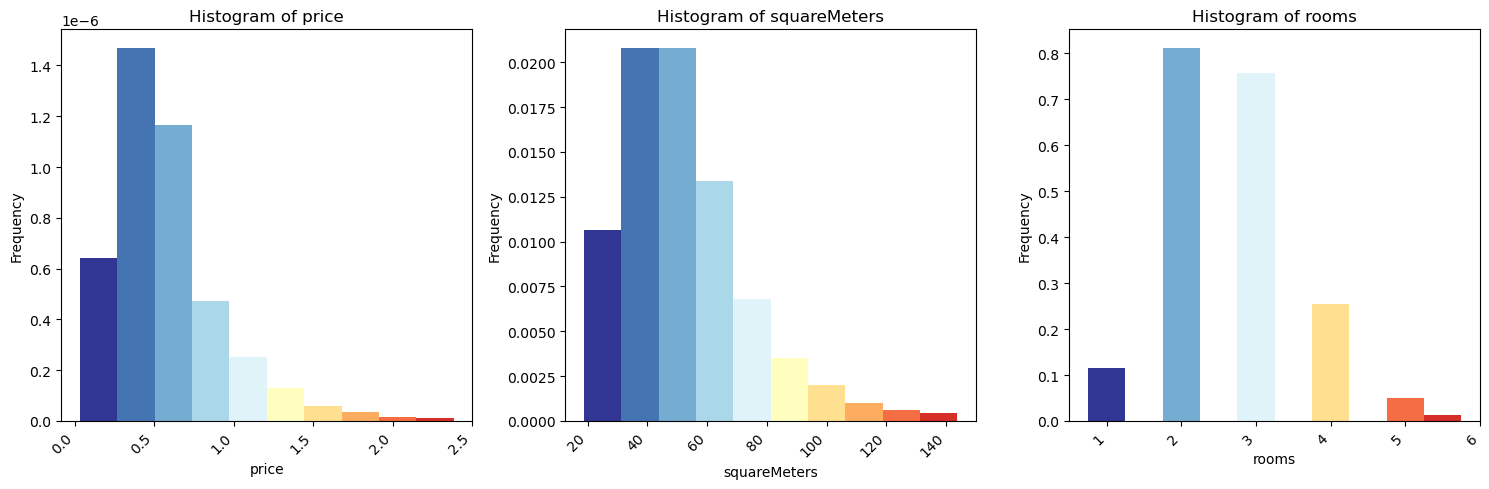

In [6]:
# Histograms
plots.create_histogram(['price', 'squareMeters', 'rooms'])

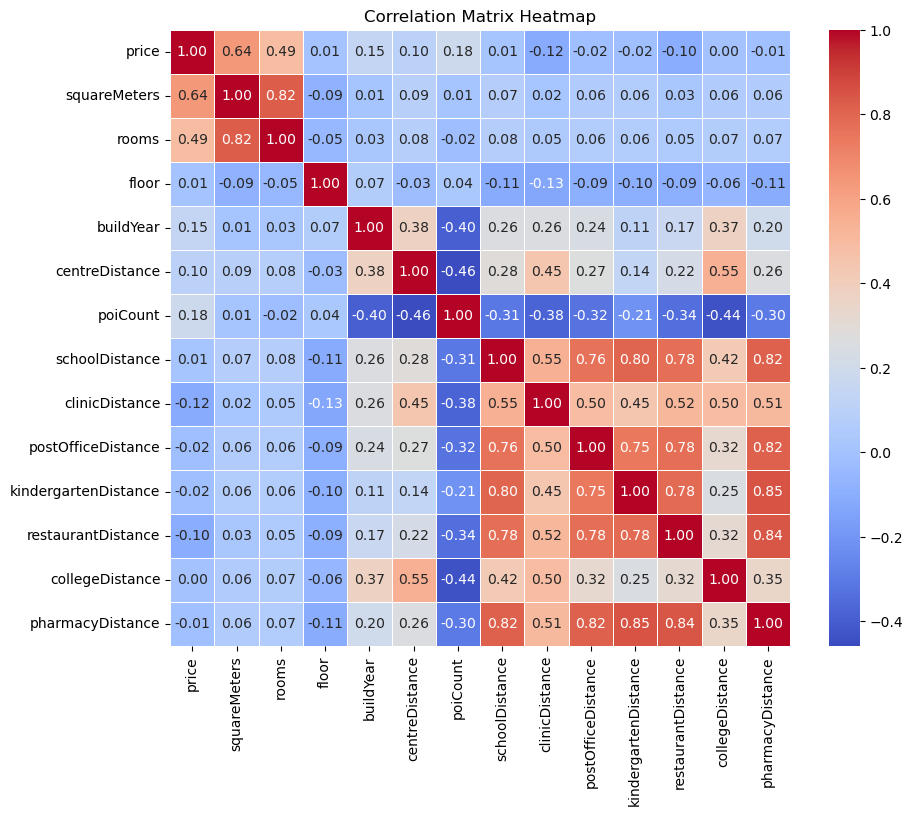

In [7]:
# Correlation matrix
corr = e.Correlation(all_data)
corr.visualize_data_correlation(['price', 'squareMeters', 'rooms', 'floor', 'buildYear', 'centreDistance', 'poiCount', 'schoolDistance', 'clinicDistance', 'postOfficeDistance', 'kindergartenDistance', 'restaurantDistance', 'collegeDistance', 'pharmacyDistance'])

## Data preprocessing

In [ ]:
# Dealing with binary variables
encoder = f.Encoding(all_data)

cols_to_encode = ['hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity', 'hasStorageRoom']
mapping_dictionary = {'yes': 1, 'no': 0}

all_data = encoder.mapping(cols_to_encode, mapping_dictionary)

In [ ]:
# Checking unique values in type
all_data['type'].unique()

In [ ]:
# Converting type to numerical so it can be imputed using KNN
encoder = f.Encoding(all_data)

mapping_dictionary = {'blockOfFlats': 1, 'tenement': 2, 'apartmentBuilding': 3}

all_data = encoder.mapping(['type'], mapping_dictionary)

### Handle missing values 

In [9]:
# Dealing with missing values
miss_fill = p.MissingValues(all_data)

In [10]:
# Missing values analysis
missing_summary = miss_fill.missing_values_summary()
print(missing_summary)

                      Missing Values  Percentage Missing
condition                      14344           75.874107
buildingMaterial                7387           39.074319
type                            4039           21.364718
floor                           3438           18.185665
buildYear                       3271           17.302301
hasElevator                      926            4.898175
collegeDistance                  565            2.988627
floorCount                       262            1.385877
clinicDistance                    88            0.465485
restaurantDistance                58            0.306797
pharmacyDistance                  27            0.142819
postOfficeDistance                25            0.132240
schoolDistance                    14            0.074054
kindergartenDistance              13            0.068765


In [11]:
# Removing columns "condition" and "building_material" as there are so many missing values
miss_fill.remove_col(['condition', 'buildingMaterial'])

# Use KNN to impute all other missing values (arbitrarily use 5 neighbors) and return updated dataframe
all_data = miss_fill.impute_missing_knn(5)

In [12]:
# Check all missing values have been filled
all_data.isna().sum()

index                      0
id                         0
city                       0
type                    4039
squareMeters               0
rooms                      0
floor                      0
floorCount                 0
buildYear                  0
latitude                   0
longitude                  0
centreDistance             0
poiCount                   0
schoolDistance             0
clinicDistance             0
postOfficeDistance         0
kindergartenDistance       0
restaurantDistance         0
collegeDistance            0
pharmacyDistance           0
ownership                  0
hasParkingSpace            0
hasBalcony                 0
hasElevator              926
hasSecurity                0
hasStorageRoom             0
price                      0
is_train                   0
dtype: int64

We now have no missing values

### Handle outliers

In [ ]:
# Define outliers class
outliers = p.Outliers(all_data)

In [ ]:
# Outlier handelling
columns_group_1 = ['squareMeters', 'rooms', 'floor', 'floorCount', 'latitude', 'longitude', 'centreDistance', 'poiCount']
# Plot outliers for the first group of numerical columns
outliers.plot_outliers(columns_group_1)

In [ ]:
# Outlier handelling
columns_group_2 = ['schoolDistance',
       'clinicDistance', 'postOfficeDistance', 'kindergartenDistance',
       'restaurantDistance', 'collegeDistance', 'pharmacyDistance']
# Plot outliers for the second group of numerical columns
outliers.plot_outliers(columns_group_2)

In [ ]:
# Plot outliers for buildYear
outliers.plot_outliers(['buildYear'])

In [ ]:
# Use standard deviation method to detect outliers
numeric_columns = all_data.select_dtypes(include=np.number).columns
outliers.detect_outliers(numeric_columns)

In [ ]:
# Winsorise numerical columns with outliers
cols_to_winsorize = ['squareMeters', 'rooms'] # Just an example, change the list of columns here!!
all_data = outliers.winsorize(cols_to_winsorize)

In [ ]:
# Check ouliers after winsorizing
outliers.detect_outliers(numeric_columns)

In [ ]:
# Replace extreme values with Null

#all_data = outliers.impute_with_null(['floor'], above=20)

# I just tested if the function works. If we want to do it, it should go before the knn part

### Encoding variables: City and ownership 

In [ ]:
# Check unique values of both
print(all_data['city'].unique())
print(all_data['ownership'].unique())

Ownership can just become a binary variable, while we will one-hot encode city, as there is no sensible variable to use for target encoding in this case.

In [ ]:
# Converting ownership column to binary
encoder = f.Encoding(all_data)
mapping_dictionary = {'condominium': 1, 'cooperative': 0}
encoder.mapping(['ownership'], mapping_dictionary)


# One-hot encoding the cities
all_data = encoder.one_hot_encoding('city')

?? Is there a reason for the date funtion in the FE file - what would we use this for in this dataset ??

### Add feature engineering here before standardising the data

Standardizing data

?? What to do with latitude and longitude, could potentially build a feature out of this ??

In [ ]:
# Standardizing all numerical columns
standard = f.Standardizer(all_data)

cols_to_standardize = ['squareMeters', 'buildYear', 'centreDistance', 'poiCount', 'schoolDistance', 'clinicDistance', 'postOfficeDistance',
                       'kindergartenDistance', 'restaurantDistance', 'collegeDistance', 'pharmacyDistance']

all_data = standard.transform(cols_to_standardize)

Modelling